In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [37]:
# read data
df_monthly_2012_2021_wt_ws = pd.read_csv('Data/monthly_data_2012_2021_wt_ws.csv', na_values='.')

c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [42]:
# date to datetime and set date as index
df_monthly_2012_2021_wt_ws['date'] = pd.to_datetime(df_monthly_2012_2021_wt_ws['date'])
df_monthly_2012_2021_wt_ws = df_monthly_2012_2021_wt_ws.sort_values(by='date')
df_monthly_2012_2021_wt_ws = df_monthly_2012_2021_wt_ws.set_index('date')

In [21]:
# drop all column and na
df_monthly_2012_2021_wt_ws_netgen = df_monthly_2012_2021_wt_ws.drop(['YEAR', 'Month', 'Reported\nPrime Mover', 'Plant Id', 'Operator Name',
                                                              'Quantity', 'Elec_Quantity', 'MMBtuPer_Unit', 'Tot_MMBtu', 'Elec_MMBtu'], axis=1)
print(len(df_monthly_2012_2021_wt_ws_netgen))
df_monthly_2012_2021_wt_ws_netgen = df_monthly_2012_2021_wt_ws_netgen.dropna()
print(len(df_monthly_2012_2021_wt_ws_netgen))
df_monthly_2012_2021_wt_ws_netgen.head()

123708
118602


,Netgen
date,
2012-01-01,2943.615
2012-01-01,4276.156
2012-01-01,571.678
2012-01-01,30221.000
2012-01-01,728.495


# Forecast of total net generation

In [213]:
# group by month and sum
df_monthly_2012_2021_wt_ws_netgen_sum = df_monthly_2012_2021_wt_ws_netgen.groupby(pd.Grouper(freq='M')).sum()

# index to datetime
df_monthly_2012_2021_wt_ws_netgen_sum.index = pd.to_datetime(df_monthly_2012_2021_wt_ws_netgen_sum.index)

In [214]:
# split train and test
train_sum = df_monthly_2012_2021_wt_ws_netgen_sum[:'2019-12-31']
test_sum = df_monthly_2012_2021_wt_ws_netgen_sum['2020-01-31':]

In [215]:
order = [(0, 0, 0), (1, 0, 0), (0, 0, 1), (1, 0, 1), (2, 0, 1), (1, 0, 2), (2, 0, 2),
         (0, 1, 0), (1, 1, 0), (0, 1, 1), (1, 1, 1), (2, 1, 1), (1, 1, 2), (2, 1, 2),
         (0, 2, 0), (1, 2, 0), (0, 2, 1), (1, 2, 1), (2, 2, 1), (1, 2, 2), (2, 2, 2)]
seasonal_order = [(0, 0, 0, 12), (1, 0, 0, 12), (0, 0, 1, 12), (1, 0, 1, 12), (2, 0, 1, 12), (1, 0, 2, 12), (2, 0, 2, 12),
                  (0, 1, 0, 12), (1, 1, 0, 12), (0, 1, 1, 12), (1, 1, 1, 12), (2, 1, 1, 12), (1, 1, 2, 12), (2, 1, 2, 12),
                  (0, 2, 0, 12), (1, 2, 0, 12), (0, 2, 1, 12), (1, 2, 1, 12), (2, 2, 1, 12), (1, 2, 2, 12), (2, 2, 2, 12)]

In [56]:
# loop sarima order and seasonal order
order_list = []
seasonal_order_list = []
error_list = []

for i in order:
    for j in seasonal_order:
        model = SARIMAX(train_sum, order=i, seasonal_order=j)
        results = model.fit()
        start = '2020-01-31'
        end = '2021-12-31'
        predictions = results.predict(start, end, typ='levels').rename('SARIMA Predictions')
        error = mean_squared_error(test_sum, predictions)
        root_error = np.sqrt(error)
        order_list.append(i)
        seasonal_order_list.append(j)
        error_list.append(root_error)

c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as s

In [57]:
# create a dataframe to store the results
df_sarima_sum_results = pd.DataFrame({'order': order_list, 'seasonal_order': seasonal_order_list, 'error': error_list})

# print the top 5 results
print(df_sarima_sum_results.sort_values(by='error', ascending=True).head())

# export the results
#df_sarima_sum_results.to_csv(r"C:\Users\danie\Downloads\sprint\sarima_results.csv")

         order seasonal_order         error
410  (1, 2, 2)  (2, 1, 1, 12)  2.934967e+06
431  (2, 2, 2)  (2, 1, 1, 12)  2.937526e+06
408  (1, 2, 2)  (0, 1, 1, 12)  2.955266e+06
411  (1, 2, 2)  (1, 1, 2, 12)  2.965280e+06
409  (1, 2, 2)  (1, 1, 1, 12)  2.982249e+06


c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Total Net Generation (MWh)')]

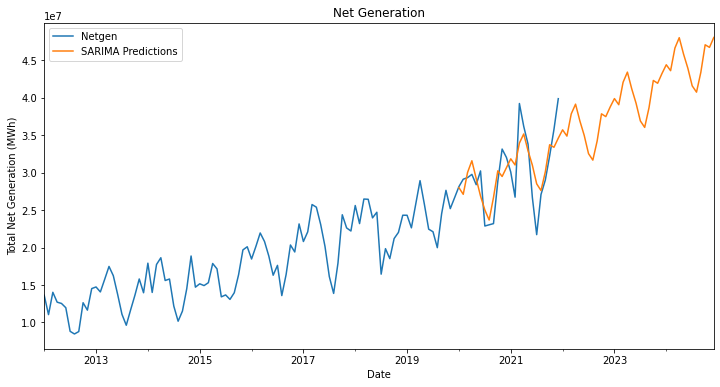

In [216]:
# fit sarima model using the best parameters
model = SARIMAX(train_sum['Netgen'], order=(1, 2, 2), seasonal_order=(2, 1, 1, 12))
results = model.fit()

# predict
start = '2020-01-31'
end = '2024-12-31'
predictions = results.predict(start, end, typ='levels').rename('SARIMA Predictions')

# plot whole length of data with prediction
ax = df_monthly_2012_2021_wt_ws_netgen_sum['Netgen'].plot(legend=True, figsize=(12, 6), title='Net Generation')
predictions.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel='Date', ylabel='Total Net Generation (MWh)')


In [217]:
# merge actual and prdiction

df_monthly_2012_2021_wt_ws_netgen_sum = pd.DataFrame(df_monthly_2012_2021_wt_ws_netgen_sum, columns=['Netgen'])
# merge prediction to df_monthly_2012_2021_wt_ws_netgen_mean
df_monthly_2012_2021_wt_ws_netgen_sum = pd.merge(df_monthly_2012_2021_wt_ws_netgen_sum, predictions, how='outer', left_index=True, right_index=True)
df_monthly_2012_2021_wt_ws_netgen_sum.to_csv('Data/df_monthly_2012_2021_wt_ws_netgen_sum_2y.csv')

In [218]:
# groupby by year and sum
df_yearly_2012_2021_wt_ws_netgen_sum = df_monthly_2012_2021_wt_ws.groupby(pd.Grouper(freq='Y')).sum()

# group prediction by year and sum
predictions_yearly = predictions.groupby(pd.Grouper(freq='Y')).sum()

In [219]:
df_yearly_2012_2021_wt_ws_netgen_sum = df_yearly_2012_2021_wt_ws_netgen_sum['Netgen'].head()

In [220]:
# concat prediction[ minus first year] and actual
df_yearly_2012_2021_wt_ws_netgen_sum = pd.concat([df_yearly_2012_2021_wt_ws_netgen_sum, predictions_yearly[1:]])

In [221]:
df_yearly_2012_2021_wt_ws_netgen_sum = pd.DataFrame(df_yearly_2012_2021_wt_ws_netgen_sum, columns=['Netgen'])

In [223]:
# calculated % change
df_yearly_2012_2021_wt_ws_netgen_sum['%_change'] = df_yearly_2012_2021_wt_ws_netgen_sum['Netgen'].pct_change()

In [224]:
df_yearly_2012_2021_wt_ws_netgen_sum

,Netgen,%_change
2012-12-31,1.408217e+08,NaN
2013-12-31,1.678397e+08,0.191860
2014-12-31,1.816553e+08,0.082314
2015-12-31,1.907185e+08,0.049893
2016-12-31,2.269926e+08,0.190197
2021-12-31,3.836281e+08,0.690047
2022-12-31,4.317102e+08,0.125335
2023-12-31,4.836637e+08,0.120344
2024-12-31,5.395980e+08,0.115647
